C:\Users\Nicol\AppData\Local\Temp\ipykernel_3260\2592621982.py:98: RuntimeWarning: invalid value encountered in divide
  acc_matrix = G * m[np.newaxis, :, np.newaxis] * dxij / distances[..., np.newaxis]**3


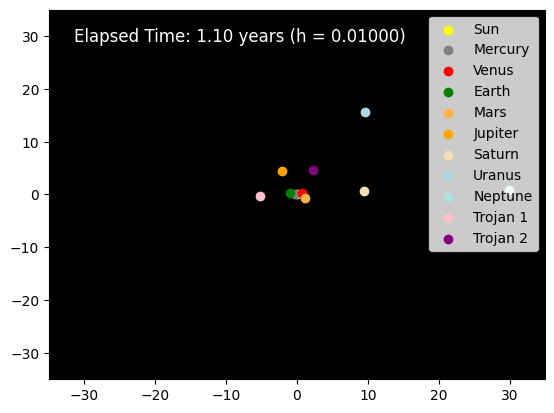

In [2]:
#Show off code

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from jplephem.spk import SPK

#Final version 

# Constants
G = 4 * np.pi**2  # Gravitational constant in AU^3 / (yr^2 * Msun)
kmtoAu = 1.0 / 149597870.7  # Conversion factor: km to AU
julian_date = 2460703.5  # Example Julian date
days_per_year = 365.25  # Days in a year

# Masses of celestial bodies (in solar masses)
sunmass = 1.988416 * 10**30  # kg
masses = np.array([
    1,  # Sun
    (3.3 * 10**23) / sunmass,  # Mercury
    (4.87 * 10**24) / sunmass,  # Venus
    (5.97 * 10**24) / sunmass,  # Earth
    (6.42 * 10**23) / sunmass,  # Mars
    (1.898 * 10**27) / sunmass,  # Jupiter
    (5.68 * 10**26) / sunmass,  # Saturn
    (8.68 * 10**25) / sunmass,  # Uranus
    (1.02 * 10**26) / sunmass,  # Neptune
    0,  # Trojan 1
    0   # Trojan 2
])

# Load ephemeris file
eph = SPK.open('de430.bsp')

# Extract the Sun's position and velocity relative to the SSB
sun_position, sun_velocity = eph[0, 10].compute_and_differentiate(julian_date)
sun_position_au = np.array(sun_position) * kmtoAu
sun_velocity_au_year = np.array(sun_velocity) * kmtoAu * days_per_year

# Initialize arrays for positions and velocities
position_rows = []
velocity_rows = []

# Add the Sun at (0,0,0)
position_rows.append([0, 0, 0])
velocity_rows.append([0, 0, 0])

# List of planetary SPK IDs (Mercury to Neptune)
spk_ids = [1, 2, 3, 4, 5, 6, 7, 8]

# Loop through celestial bodies
for i, planet_id in enumerate(spk_ids):
    # Get planet's position and velocity relative to the SSB
    (x, y, z), (vx, vy, vz) = eph[0, planet_id].compute_and_differentiate(julian_date)

    # Convert positions to AU and adjust relative to the Sun
    x = x * kmtoAu - sun_position_au[0]
    y = y * kmtoAu - sun_position_au[1]
    z = z * kmtoAu - sun_position_au[2]

    # Convert velocities to AU/year and adjust relative to the Sun
    vx = vx * kmtoAu * days_per_year - sun_velocity_au_year[0]
    vy = vy * kmtoAu * days_per_year - sun_velocity_au_year[1]
    vz = vz * kmtoAu * days_per_year - sun_velocity_au_year[2]

    # Append to rows
    position_rows.append([x, y, z])
    velocity_rows.append([vx, vy, vz])

# Add Trojan bodies (positions/velocities)
position_rows.append([-4.503, 2.6, 0])  # Trojan 1
velocity_rows.append([-1.38, -2.39, 0])

position_rows.append([4.503, 2.6, 0])  # Trojan 2
velocity_rows.append([-1.38, 2.39, 0])

# Convert to NumPy arrays
positionMatrix = np.array(position_rows)
velocityMatrix = np.array(velocity_rows)

# Combine into the state matrix
S = np.hstack((positionMatrix, velocityMatrix))
initial_state = S.copy()

# Acceleration function
def acceleration(S_matrix, m):
    dS = np.zeros_like(S_matrix)
    dS[:, :3] = S_matrix[:, 3:6]  # Velocities

    pos = S_matrix[:, :3]
    xi = pos[:, np.newaxis]
    xj = pos[np.newaxis]
    dxij = xi - xj

    distances = np.linalg.norm(dxij, axis=2) 
    acc_matrix = G * m[np.newaxis, :, np.newaxis] * dxij / distances[..., np.newaxis]**3

    acc_matrix[0, :, :] = 0  # No forces act on the Sun
    dS[:, 3:6] = -np.nansum(acc_matrix, axis=1)  # Sum forces
    return dS

def RungeKutta(S_matrix, mass,h):
    k1 = acceleration(S, masses) * h
    k2 = acceleration(S + k1 / 2, masses) * h
    k3 = acceleration(S + k2 / 2, masses) * h
    k4 = acceleration(S + k3, masses) * h
    S_matrix += (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return S_matrix




def energy_drift(tmax,h,S,mass):
    totEnergy = []
    mass = mass*1.988416 * 10**30 #convert from Msol to kg
    AU_meters = 1.495978707e11  # 1 AU in meters
    secondstot = 365.25 * 24 * 3600  # Seconds in a year
    AUms = AU_meters / secondstot #Au to m/s

    t =0
    while t < tmax:
        kineticEnergy = np.sum(0.5 * mass * np.sum(((S[:, 3:6])*AUms)**2, axis=1))
        positions = S[:, :3]
        ri = positions[:,np.newaxis]
        rj = positions[np.newaxis]
        drij = ri-rj
        r = np.linalg.norm(drij, axis=2)
        np.fill_diagonal(r,np.inf) #avoid self-interaction
        G = 4*np.pi**(2)
        potential_matrix = -G* mass[:,np.newaxis]*mass[np.newaxis, :]/r[..., np.newaxis]
        potential_energy = np.sum(np.triu(potential_matrix, k =1)) 
        #k=1 indicates that we exclude i=j and triu is the summation of the upper triangle since by symmetry Uij = Uji
        gamma = kineticEnergy+potential_energy
        totEnergy.append(gamma)
        S = RungeKutta(S,mass,h)
        t+=h
    
    energy_fig = plt.figure()
    xspace = np.arange(0,tmax,h)
    xspace = np.append(np.arange(0, tmax, h), tmax)
    plt.plot(xspace,totEnergy)
    text = "Drift energy for " + str(tmax) + " years with h = " + str(h)  
    plt.xlabel("Time (years)")
    plt.ylabel("Total Energy (J)")

    plt.title(text)
    plt.show(block=False)

def Orbits(tmax,h,S_matrix2,mass, _scale):
    t = 0
    steps = int(tmax / h) + 1
    mercuryPos = np.zeros((steps,2))
    venusPos = np.zeros((steps,2))
    earthPos = np.zeros((steps,2))
    marsPos = np.zeros((steps,2))
    jupiterPos = np.zeros((steps,2))
    saturnPos = np.zeros((steps,2))
    uranusPos = np.zeros((steps,2))
    neptunePos = np.zeros((steps,2))
    troj1Pos = np.zeros((steps,2))
    troj2Pos = np.zeros((steps,2))
    index = 0
    #Extracting positions
    while t < tmax:
        print(t)
        S_matrix2 = RungeKutta(S_matrix2,mass,h)
        xlist2 = S_matrix2[:, 0]
        ylist2 = S_matrix2[:, 1]    
        mercuryPos[index, 0], mercuryPos[index, 1] = xlist2[1], ylist2[1]
        venusPos[index, 0], venusPos[index, 1] = xlist2[2], ylist2[2]
        earthPos[index, 0], earthPos[index, 1] = xlist2[3], ylist2[3]
        marsPos[index, 0], marsPos[index, 1] = xlist2[4], ylist2[4]
        jupiterPos[index, 0], jupiterPos[index, 1] = xlist2[5], ylist2[5]
        saturnPos[index, 0], saturnPos[index, 1] = xlist2[6], ylist2[6]
        uranusPos[index, 0], uranusPos[index, 1] = xlist2[7], ylist2[7]
        neptunePos[index, 0], neptunePos[index, 1] = xlist2[8], ylist2[8]
        troj1Pos[index, 0], troj1Pos[index, 1] = xlist2[9], ylist2[9]
        troj2Pos[index, 0], troj2Pos[index, 1] = xlist2[10], ylist2[10]     
        t+= h
        index+=1

    # Plot orbits
    orbit_fig = plt.figure()

    #Filter out Mercury’s positions based on x and y thresholds** DONT CHANGE BELOW 0.5, instability in visualisation
    x_threshold = 0.5
    y_threshold = 0.5

    mercury_filtered = mercuryPos[
        (np.abs(mercuryPos[:, 0]) < x_threshold) & 
        (np.abs(mercuryPos[:, 1]) < y_threshold)
    ]
    
    

    plt.plot(mercury_filtered[:, 0], mercury_filtered[:, 1], label="Mercury", color="Gray")
    #plt.plot(mercuryPos[:, 0], mercuryPos[:, 1], label="Mercury", color = "Gray")
    plt.plot(venusPos[:, 0], venusPos[:, 1], label="Venus", color = "Red")
    plt.plot(earthPos[:, 0], earthPos[:, 1], label="Earth", color = "Green")
    plt.plot(marsPos[:, 0], marsPos[:, 1], label="Mars", color = "#ffb347")
    plt.plot(jupiterPos[:, 0], jupiterPos[:, 1], label="Jupiter", color = "Orange" )
    plt.plot(saturnPos[:, 0], saturnPos[:, 1], label="Saturn", color ="Wheat" )
    plt.plot(uranusPos[:, 0], uranusPos[:, 1], label="Uranus", color = "LightBlue")
    plt.plot(neptunePos[:, 0], neptunePos[:, 1], label="Neptune", color = "PowderBlue")
    plt.plot(troj1Pos[:, 0], troj1Pos[:, 1], label="Trojan 1", color = "Pink")
    plt.plot(troj2Pos[:, 0], troj2Pos[:, 1], label="Trojan 2", color= "Purple")

    # Plot the Sun at the origin
    plt.scatter(0, 0, color="yellow", label="Sun")

    # Customize the plot
    plt.xlabel("x (AU)")
    plt.ylabel("y (AU)")
    plt.title(f"Orbits of Planets for {tmax} years")
    plt.legend(loc="upper right")
    plt.xlim(-_scale,_scale)
    plt.ylim(-_scale,_scale)
    plt.show()

def Rotational(tmax,h,S_matrix3,mass):
    #velocities are in au/year
    #distance in au
    mass = mass*1.988416 * 10**30 #convert from Msol to kg
    planetsmass = mass[1:] #excluding sun mass
    G = 4*np.pi**(2)
    t =0
    while t < tmax:
        S_matrix3 = RungeKutta(S_matrix3,mass,h)
        t+=h
    
    vxlist2 = S_matrix3[:, 3]
    vylist2 = S_matrix3[:, 4]

    xlist3 = S_matrix3[:, 0]
    ylist3 = S_matrix3[:, 1]    
    #Radial velocity in x and y plane, neglecting z component
    mercuryVel = np.sqrt((vxlist2[1]**(2))+(vylist2[1]**(2)))
    venusVel = np.sqrt((vxlist2[2]**(2))+(vylist2[2]**(2)))
    earthVel = np.sqrt((vxlist2[3]**(2))+(vylist2[3]**(2)))
    marsVel = np.sqrt((vxlist2[4]**(2))+(vylist2[4]**(2)))
    jupiterVel = np.sqrt((vxlist2[5]**(2))+(vylist2[5]**(2)))
    saturnVel = np.sqrt((vxlist2[6]**(2))+(vylist2[6]**(2)))
    urnausVel = np.sqrt((vxlist2[7]**(2))+(vylist2[7]**(2)))
    neptuneVel = np.sqrt((vxlist2[8]**(2))+(vylist2[8]**(2)))
    trojan1Vel = np.sqrt((vxlist2[9]**(2))+(vylist2[9]**(2)))
    trojan2Vel = np.sqrt((vxlist2[10]**(2))+(vylist2[10]**(2)))

    #Radial distance
    mercuryR = np.sqrt((xlist3[1]**(2))+(ylist3[1]**(2)))
    venusR = np.sqrt((xlist3[2]**(2))+(ylist3[2]**(2)))
    earthR = np.sqrt((xlist3[3]**(2))+(ylist3[3]**(2)))
    marsR = np.sqrt((xlist3[4]**(2))+(ylist3[4]**(2)))
    jupiterR = np.sqrt((xlist3[5]**(2))+(ylist3[5]**(2)))
    saturnR = np.sqrt((xlist3[6]**(2))+(ylist3[6]**(2)))
    urnausR = np.sqrt((xlist3[7]**(2))+(ylist3[7]**(2)))
    neptuneR = np.sqrt((xlist3[8]**(2))+(ylist3[8]**(2)))
    trojan1R = np.sqrt((xlist3[9]**(2))+(ylist3[9]**(2)))
    trojan2R = np.sqrt((xlist3[10]**(2))+(ylist3[10]**(2)))

    plt.plot(mercuryR, mercuryVel, label="Mercury", color = "Gray")
    plt.scatter(venusR, venusVel, label="Venus", color = "Red")
    plt.scatter(earthR, earthVel, label="Earth", color = "Green")
    plt.scatter(marsR, marsVel, label="Mars", color = "#ffb347")
    plt.scatter(jupiterR, jupiterVel, label="Jupiter", color = "Orange" )
    plt.scatter(saturnR, saturnVel, label="Saturn", color ="Wheat" )
    plt.scatter(urnausR, urnausVel, label="Uranus", color = "LightBlue")
    plt.scatter(neptuneR, neptuneVel, label="Neptune", color = "PowderBlue")
    plt.scatter(trojan1R, trojan1Vel, label="Trojan 1", color = "Pink")
    plt.scatter(trojan2R, trojan2Vel, label="Trojan 2", color= "Purple")

    title = "Rotational Velocity t = " + str(tmax) + " years"
    plt.title(title)
    plt.xlabel("Radial distance (Au)")
    plt.ylabel("Rotational velocity (Au/year)")
    plt.xlim(0,10)
    plt.ylim(0,10)
    plt.legend()
    plt.show()

#Plotting functions

#tmax is the end time of the simulation for the plot
#energy_drift(300,0.01,initial_state,masses)


# scale parameter determines the zooming of the plot
#Orbits(100,0.01,S,masses,50) #default tmax = 30

#Rotational(50,0.01,S,masses) 

# Animation update function

elapsed_time = 0
timestep = 0.01  # Animation interval (ms) (unrelated to calculations)

def update(frame):
    global S, elapsed_time

    #h = 0.01
    #adaptive time steps
    if elapsed_time < 5:
        h = 0.01 #0.01
    elif elapsed_time < 95:
        h = 0.005
    elif elapsed_time < 300:
        h = 0.002
    if elapsed_time >= 300:
        S[:] = initial_state
        elapsed_time = 0
        print("Simulation reset")

    # Runge-Kutta integration 
    S = RungeKutta(S,masses,h)

    elapsed_time += h

    xlist = S[:, 0]
    ylist = S[:, 1]

    # Update positions in the plot
    sun.set_offsets([xlist[0], ylist[0]])
    mercury.set_offsets([xlist[1], ylist[1]])
    venus.set_offsets([xlist[2], ylist[2]])
    earth.set_offsets([xlist[3], ylist[3]])
    mars.set_offsets([xlist[4], ylist[4]])
    jupiter.set_offsets([xlist[5], ylist[5]])
    saturn.set_offsets([xlist[6], ylist[6]])
    uranus.set_offsets([xlist[7], ylist[7]])
    neptune.set_offsets([xlist[8], ylist[8]])
    trojan1.set_offsets([xlist[9], ylist[9]])
    trojan2.set_offsets([xlist[10], ylist[10]])

    # Update elapsed time label
    time_label.set_text(f"Elapsed Time: {elapsed_time:.2f} years (h = {h:.5f})") #after each tick we update the label
    return sun, mercury, venus, earth, mars, jupiter, saturn, uranus, neptune, trojan1, trojan2, time_label

# Tkinter setup
root = tk.Tk()
root.title("The Solar System")

# Enable full-screen mode
#root.attributes("-fullscreen", True)

fig, ax = plt.subplots()
scale_parameter = 35
ax.set_xlim(-scale_parameter, scale_parameter)
ax.set_ylim(-scale_parameter, scale_parameter)

# Scatter plots for celestial bodies
sun = ax.scatter(S[0, 0], S[0, 1], color="Yellow", label="Sun")
mercury = ax.scatter(S[1, 0], S[1, 1], color="Gray", label="Mercury")
venus = ax.scatter(S[2, 0], S[2, 1], color="Red", label="Venus")
earth = ax.scatter(S[3, 0], S[3, 1], color="Green", label="Earth")
mars = ax.scatter(S[4, 0], S[4, 1], color="#ffb347", label="Mars")
jupiter = ax.scatter(S[5, 0], S[5, 1], color="Orange", label="Jupiter")
saturn = ax.scatter(S[6, 0], S[6, 1], color="Wheat", label="Saturn")
uranus = ax.scatter(S[7, 0], S[7, 1], color="LightBlue", label="Uranus")
neptune = ax.scatter(S[8, 0], S[8, 1], color="PowderBlue", label="Neptune")
trojan1 = ax.scatter(S[9, 0], S[9, 1], color="Pink", label="Trojan 1")
trojan2 = ax.scatter(S[10, 0], S[10, 1], color="Purple", label="Trojan 2")

# Add elapsed time label
time_label = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top', color = 'White')

canvas = FigureCanvasTkAgg(fig, master=root)
canvas_widget = canvas.get_tk_widget()
canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

ani = animation.FuncAnimation(
    fig, update, frames=1, interval=timestep, blit=True
)

plt.legend(loc="upper right")
#plt.grid()
ax.set_facecolor('black')
root.mainloop()


FAIR data principles

This workflow is findable in the sense that it is published on GitHub publicly together with the related report. The algorithm will be publicly accessible for free and thus follows FAIR use, allowing for detailed examination of the code as well as modifying it directly for future use. Furthermore, metadata is provided with the README.txt file which also provides instructions on how to properly run the animation of the simulation. Since the project was coded in Python, the interoperability is great as of today due to Python being a standardized language in scientific research, with vast support across many interfaces such as Visual Code, Spyder, and Google Colab. The algorithm is also provided in a Jupyter Notebook format (ipynb) which allows for direct debugging of the algorithm, making it easily accessible. This workflow will be published under a Creative Commons license to allow for future development, allowing for reusability of the workflow. The algorithm and the README.txt file provide specific details on certain parts of the algorithm in order to clarify the process behind the simulation.